In [1]:
!pip install split-folders
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import splitfolders

from tqdm import tqdm_notebook, tqdm
from warnings import filterwarnings as fws
fws('ignore')

Segmentation Models: using `keras` framework.


In [3]:
ROOT = '/kaggle/input/capstone-disease-segmentation/DISEASE_SEGMENTATION'
splitfolders.ratio(ROOT, output="output", seed=143, ratio=(.9, 0,0.1))

Copying files: 1956 files [00:04, 392.47 files/s]


In [4]:
train_image_dir = '/kaggle/working/output/train/images'
train_mask_dir = '/kaggle/working/output/train/masks'

In [5]:
train_images = []

for directory_path in glob.glob(train_image_dir):
    img_path = glob.glob(os.path.join(directory_path, "*.jpg"))
    img_path.sort()
    for i in tqdm_notebook(img_path):
        img = cv2.imread(i)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        train_images.append(img)
        
train_images = np.array(train_images)

  0%|          | 0/880 [00:00<?, ?it/s]

In [6]:
train_masks = [] 

for directory_path in glob.glob(train_mask_dir):
    msk_path = glob.glob(os.path.join(directory_path, "*.png"))
    msk_path.sort()
    for i in tqdm_notebook(msk_path):
        mask = cv2.imread(i)
        mask = cv2.resize(mask, (256, 256))
        mask = np.where(mask==True, 255, 0).astype('uint8')
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        train_masks.append(mask)
        
train_masks = np.array(train_masks)

  0%|          | 0/880 [00:00<?, ?it/s]

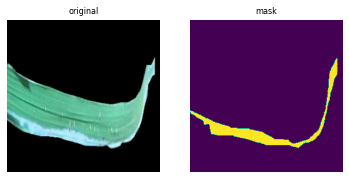

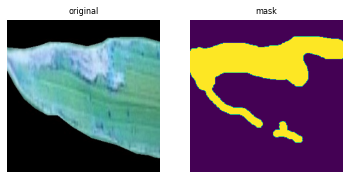

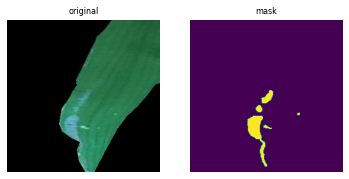

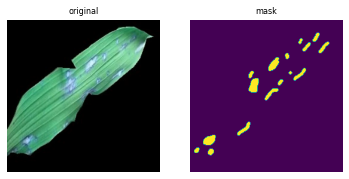

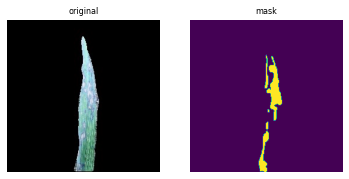

In [7]:
for idx in range(5):
    fig, axs = plt.subplots(nrows=1, ncols=2)

    axs[0].imshow(train_images[idx])
    axs[0].set_title('original', fontsize=8)

    axs[1].imshow(train_masks[idx])
    axs[1].set_title('mask', fontsize=8)

    for i in range(2):
        axs[i].axis('off')

    plt.show()

In [8]:
from albumentations import (
    Compose,
    RandomRotate90,
    Flip,
    Transpose,
    RandomSizedCrop,
    RandomBrightnessContrast,
    RandomGamma,
    Rotate,
    Normalize
)
def augment(image, mask):
    augmentations = Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        RandomBrightnessContrast(p=0.5),
        RandomGamma(p=0.5),
        Rotate(),
        Normalize()
    ])

    augmented = augmentations(image=image, mask=mask)
    image = augmented['image']
    mask = augmented['mask']

    return image, mask

In [9]:
def scale_image(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

augmented_images, augmented_masks = [], []
for image, mask in tqdm_notebook(zip(train_images, train_masks)):
    
    for _ in range(2):
        aug_img, aug_msk = augment(image, mask)
        aug_img = cv2.resize(aug_img, (256, 256))

        augmented_images.append(scale_image(aug_img))
        augmented_masks.append((aug_msk/255).astype('uint8'))

0it [00:00, ?it/s]

In [10]:
X = np.array(augmented_images)
Y = np.array(augmented_masks)

print('x_min', X.min())
print('x_min', X.max())
print('y_min', Y.min())
print('y_min', Y.max(), '\n')
print(X.shape)
print(Y.shape)

x_min 0.0
x_min 1.0
y_min 0
y_min 1 

(1760, 256, 256, 3)
(1760, 256, 256)


In [11]:
from sklearn.model_selection import train_test_split
from segmentation_models import metrics

sm.set_framework('tf.keras')
sm.framework()

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

# preprocess input
BACKBONE = 'resnet50'

preprocess_input = sm.get_preprocessing(BACKBONE)
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.FScore()])

print(model.summary())

2023-01-27 20:54:05.820554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 20:54:05.903988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 20:54:05.904762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 20:54:05.906571: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94601216/94592056 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
___________________________

In [12]:
from keras.callbacks import ModelCheckpoint

# early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')
filepath = "resnet50-disease-segmentor.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_f1-score', verbose=1, save_best_only=True, mode='max')


history = model.fit(x_train, y_train,
                    batch_size=32, 
                    epochs=100,
                    verbose=1,
                    validation_data=(x_val, y_val), 
                    callbacks=[checkpoint])

2023-01-27 20:55:11.548980: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 968884224 exceeds 10% of free system memory.
2023-01-27 20:55:12.732832: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 968884224 exceeds 10% of free system memory.
2023-01-27 20:55:13.594697: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-27 20:55:20.034366: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


39/39 [==============================] - ETA: 0s - loss: 0.2589 - accuracy: 0.9505 - f1-score: 0.1489

2023-01-27 20:55:43.742106: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 415236096 exceeds 10% of free system memory.
2023-01-27 20:55:44.244267: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 415236096 exceeds 10% of free system memory.


39/39 [==============================] - 34s 515ms/step - loss: 0.2589 - accuracy: 0.9505 - f1-score: 0.1489 - val_loss: 0.3892 - val_accuracy: 0.9356 - val_f1-score: 0.0496

Epoch 00001: val_f1-score improved from -inf to 0.04961, saving model to resnet50-disease-segmentor.h5
Epoch 2/100
39/39 [==============================] - 16s 411ms/step - loss: 0.0750 - accuracy: 0.9849 - f1-score: 0.3716 - val_loss: 0.1767 - val_accuracy: 0.9741 - val_f1-score: 0.0540

Epoch 00002: val_f1-score improved from 0.04961 to 0.05404, saving model to resnet50-disease-segmentor.h5
Epoch 3/100
39/39 [==============================] - 16s 409ms/step - loss: 0.0511 - accuracy: 0.9856 - f1-score: 0.4931 - val_loss: 0.1308 - val_accuracy: 0.9741 - val_f1-score: 0.0340

Epoch 00003: val_f1-score did not improve from 0.05404
Epoch 4/100
39/39 [==============================] - 16s 409ms/step - loss: 0.0403 - accuracy: 0.9873 - f1-score: 0.5764 - val_loss: 0.1205 - val_accuracy: 0.9741 - val_f1-score: 0.0260



In [13]:
import pandas as pd

results_df = pd.DataFrame(history.history)
results_df.to_csv('81_disease_segmentor_adam.csv', index=False)
results_df

,loss,accuracy,f1-score,val_loss,val_accuracy,val_f1-score
0,0.258906,0.950476,0.148896,0.389238,0.935597,0.049607
1,0.075034,0.984915,0.371631,0.176729,0.974061,0.054044
2,0.051072,0.985648,0.493114,0.130791,0.974061,0.034018
3,0.040323,0.987258,0.576374,0.120526,0.974061,0.026000
4,0.034825,0.988174,0.625040,0.125022,0.974061,0.017520
...,...,...,...,...,...,...
95,0.005132,0.997907,0.945522,0.041373,0.990717,0.805915
96,0.004865,0.998013,0.948101,0.041299,0.990757,0.808967
97,0.004592,0.998119,0.950803,0.041938,0.990832,0.810091
98,0.004466,0.998159,0.952669,0.042310,0.990786,0.810073


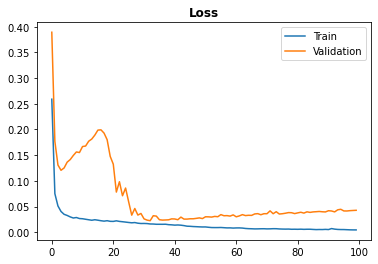

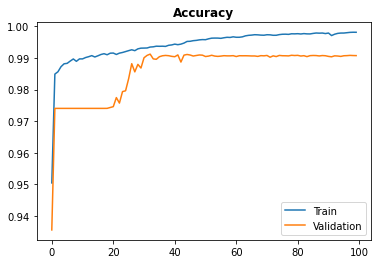

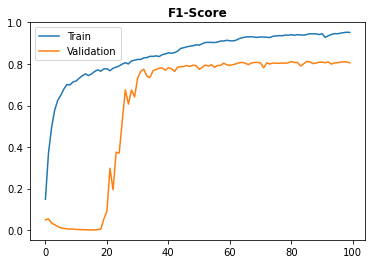

In [14]:
plt.plot(results_df['loss'], label='Train')
plt.plot(results_df['val_loss'], label='Validation')
plt.title('Loss', fontweight='bold')
plt.legend()
plt.show()

plt.plot(results_df['accuracy'], label='Train')
plt.plot(results_df['val_accuracy'], label='Validation')
plt.title('Accuracy', fontweight='bold')
plt.legend()
plt.show()

plt.plot(results_df['f1-score'], label='Train')
plt.plot(results_df['val_f1-score'], label='Validation')
plt.title('F1-Score', fontweight='bold')
plt.legend()
plt.show()

In [15]:
from tensorflow import keras
saved_model = keras.models.load_model('/kaggle/working/resnet50-disease-segmentor.h5', compile=False)

In [18]:
def predict(image, threshold=0.7):
#     step1 = preprocess(image)
    step2 = np.expand_dims(image, axis=0)
    
    prediction = saved_model.predict(step2, verbose='silent')
    pred_image = np.squeeze(prediction > threshold)
    return pred_image.astype('uint8')

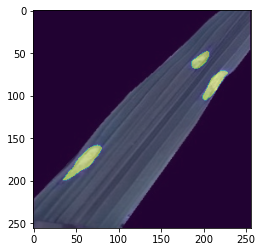

In [26]:
idx = 18
plt.imshow(x_val[idx])
plt.imshow(predict(x_val[idx]), alpha=0.5)